In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer
import random
import os
import math
import pylab as p
import seaborn as sns
from datetime import datetime, timedelta
import string

In [2]:
file_path_volts1 = r".\dataset\H1\Tagged_Training_10_22_1350889201\LF1V.csv"
file_path_amps1 = r".\dataset\H1\Tagged_Training_10_22_1350889201\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H1\Tagged_Training_10_22_1350889201\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H1\Tagged_Training_10_22_1350889201\LF2V.csv"
file_path_amps2 = r".\dataset\H1\Tagged_Training_10_22_1350889201\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H1\Tagged_Training_10_22_1350889201\TimeTicks2.csv"

file_path_tagging_info = r".\dataset\H1\Tagged_Training_10_22_1350889201\TaggingInfo.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

tagging_info = pd.read_csv(file_path_tagging_info)

In [3]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [4]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

In [5]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
time_ticks1_np = np.array(time_ticks1)
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
time_ticks2_np = np.array(time_ticks2)
TS2_real = np.array(time_ticks2_datetime)

In [6]:
data = pd.DataFrame()
len = min(len(L1_actual_power), len(L2_actual_power))

data["Phase1_actual"] = L1_actual_power[:len]
data["Phase1_real"] = L1_real[:len]
data["Phase1_img"] = L1_imag[:len]
data["Phase1_app"] = L1_app[:len]
data["Phase1_time"] = time_ticks1_np[:len]

data["Phase2_actual"] = L2_actual_power[:len]
data["Phase2_real"] = L2_real[:len]
data["Phase2_img"] = L2_imag[:len]
data["Phase2_app"] = L2_app[:len]
data["Phase2_time"] = time_ticks2_np[:len]

# Event detection

### Smooth the data a little bit

In [7]:
def moving_average(array, window):
    moving_avg = np.convolve(array, np.ones(window) / window, mode='valid')
    return moving_avg

### Normalize the data

In [8]:
def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

### CUSUM

In [9]:
def detect_cusum(array, threshold, drift):
    sum_positive = np.zeros(array.size)
    sum_negative = np.zeros(array.size)
    event_index_start = np.array([[], [], []], dtype=int)
    event_index_end = np.array([[], [], []], dtype=int)

    for i in range(1, array.size):
        sum = array[i] - array[i-1]

        # sums for positive/negative changes
        sum_positive[i] = max(0, sum_positive[i-1] + sum - drift)
        sum_negative[i] = max(0, sum_negative[i-1] - sum - drift)

        # if a change is detected
        if sum_positive[i] > threshold:
            event_index_start = np.append(event_index_start, i)
            sum_positive[i], sum_negative[i] = 0, 0
            continue

        if sum_negative[i] > threshold:
            event_index_end = np.append(event_index_end, i)
            sum_positive[i], sum_negative[i] = 0, 0

    return event_index_start, event_index_end

### Since this algorithm tends to over detect, we have to clean the output a little bit

In [10]:
def filter_close_events(event_indices, min_separation):
    filtered_indices = [event_indices[0]]

    for i in range(1, event_indices.size):
        if event_indices[i] - event_indices[i - 1] >= min_separation:
            # If the time separation is greater than or equal to the threshold, keep the event
            filtered_indices.append(event_indices[i])

    return np.array(filtered_indices)

In [11]:
# Short spikes in power when an appliance starts up can be detected as an end event, so make sure that start and end events are not too close together
def filter_spikes(events_start, events_end, min_separation):
    indexes_to_delete = list()

    for iter in range(4):
        for i in range(events_start.size):
            for j in range(events_end.size):
                if events_end[j] < events_start[i]:
                    continue

                if events_end[j] - events_start[i] < min_separation:
                    indexes_to_delete.append(j)
                    break

                break

        events_end = np.delete(events_end, indexes_to_delete)
        indexes_to_delete = list()
    return events_end

In [12]:
def group_start_end(events_start, events_end):
    start_indexes = list()
    end_indexes = list()

    for i in range(events_start.size):
        for j in range(events_end.size):
            if events_end[j] < events_start[i]:
                continue

            start_indexes.append(events_start[i])
            end_indexes.append(events_end[j])
            break

    return np.array(start_indexes), np.array(end_indexes)

In [13]:
def filter_short_events(events_start, events_end, min_event_length):
    start_indexes = list()
    end_indexes = list()

    for i in range(events_start.size):
        if events_end[i] - events_start[i] >= min_event_length:
            start_indexes.append(events_start[i])
            end_indexes.append(events_end[i])

    return np.array(start_indexes), np.array(end_indexes)

# Extract labeled spikes

In [36]:
def calculate_overlap(start, end, on, off):
    return (min(end, off) - max(start, on)) / (end - start)

def find_closest_event(events_start, events_end, time_ticks, label):
    start = 0
    end = max(events_end)

    for event in range(events_start.size):
        if events_start[event] > start and time_ticks[int(events_start[event])] <= label["OnTime"]:
            start = events_start[event]

        if events_end[event] < end and time_ticks[int(events_end[event])] >= label["OffTime"]:
            end = events_end[event]

    return start, end

def extract_labeled_spikes(events_start, events_end, time_ticks, labels):
    labeled_events_start = list()
    labeled_events_end = list()
    phase_index = 0

    for index in range(labels.shape[0]):
        row = labels.iloc[index]
        found = False

        last_event = 0
        for event in range(events_start.size):
            start = int(events_start[event])
            end = int(events_end[event])

            if start <= last_event:
                phase_index += 1

            time = time_ticks[phase_index]

            if not (row["OnTime"] <= time[start] <= row["OffTime"] or row["OnTime"] <= time[end] <= row["OffTime"]):
                continue

            found = True
            overlap = calculate_overlap(time[start], time[end], row["OnTime"], row["OffTime"])
            if overlap < 0.3:
                continue

            labeled_events_start.append(start)
            labeled_events_end.append(end)

        if not found:
            start, end = find_closest_event(events_start, events_end, time_ticks[phase_index], row)
            labeled_events_start.append(start)
            labeled_events_end.append(end)

    return np.array(labeled_events_start), np.array(labeled_events_end)

In [80]:
def calculate_events(power):
    power = moving_average(power, 7)
    power = normalize(power)

    events_start, events_end = detect_cusum(power, threshold=0.009, drift=0.0005)
    events_start = filter_close_events(events_start, 60)
    events_end = filter_close_events(events_end, 60)
    events_end = filter_spikes(events_start, events_end, 12)
    events_start, events_end = group_start_end(events_start, events_end)
    events_start, events_end = filter_short_events(events_start, events_end, 100)

    return events_start, events_end

def remove_overlapping_events(events_start, events_end):
    to_remove = list()

    for index in range(1, events_start.size):
        if events_end[index] == events_end[index - 1]:
            to_remove.append(index)

    return np.delete(events_start, to_remove), np.delete(events_end, to_remove)

In [89]:
phases = ["Phase1", "Phase2"]
events_start = np.empty(0)
events_end = np.empty(0)
time_ticks = np.empty((2, len))
i = 0

for phase in phases:
    power = data[phase + "_actual"]
    time = data[phase + "_time"]

    phase_on, phase_off = calculate_events(power)
    events_start = np.append(events_start, phase_on)
    events_end = np.append(events_end, phase_off)
    time_ticks[i] = time
    i += 1

# events_start, events_end = extract_labeled_spikes(events_start, events_end, time_ticks, tagging_info)
# events_start, events_end = remove_overlapping_events(events_start, events_end)

In [82]:
print(events_start)
print(events_end)

[302367. 302980. 304553. 305339. 306060. 306716. 307412. 308220. 308877.
 309665. 310383. 313616. 314283. 315057. 315776. 316446. 317217. 317937.
 318609. 319382. 320096. 320818. 321543. 322261. 322987. 323707. 324015.
 326585. 327259. 328034. 328754. 329421. 330205. 330915. 330915. 333072.
 333746. 334513. 335234. 335906. 336676. 337400. 338068. 338841. 339542.
 339542. 341749. 342392. 343166. 343888. 343888. 346048. 346717. 347488.
 348207. 348207. 350367. 351043. 351826. 352534. 353258. 353980. 354695.
 355420. 356139. 356450. 358142.]
[302734. 304169. 304978. 305699. 306421. 307139. 307879. 308582. 309302.
 310024. 310745. 313974. 314693. 315414. 316135. 316856. 317583. 318302.
 319023. 319745. 320460. 321182. 321905. 322622. 323349. 324067. 325518.
 326950. 327673. 328404. 329119. 329847. 330562. 331270. 332726. 333439.
 334159. 334889. 335597. 336319. 337038. 337758. 338479. 339202. 339924.
 341362. 342085. 342803. 343533. 344243. 345701. 346408. 347130. 347850.
 348569. 350018. 

# Visualizing data

In [83]:
# Example date: 2023-10-10 12:00:00
def zoomIn(start_time: string, end_time: string, time_ticks):
    date_format = "%Y-%m-%d %H:%M:%S"
    # We add two hours because for some reason the start/end index are two hours short
    start_time = (datetime.strptime(start_time, date_format) + timedelta(hours=1)).timestamp()
    end_time = (datetime.strptime(end_time, date_format) + timedelta(hours=1)).timestamp()

    start_index = -1
    end_index = -1
    for index in range(TS1_real.size):
        if time_ticks[index] > start_time and start_index == -1:
            start_index = index
        if time_ticks[index] > end_time and end_index == -1:
            end_index = index
    return start_index, end_index

In [84]:
def plot_events(dataframe, start_index, end_index, time):
    for index in range(len(dataframe)):
        if not (start_index <= index <= end_index):
            continue

        if dataframe.iloc[index]["EventsStart"] == 1:
            plt.axvline(time[index], color='g', linestyle='--')

        if dataframe.iloc[index]["EventsEnd"] == 1:
            plt.axvline(time[index], color='m', linestyle='--')

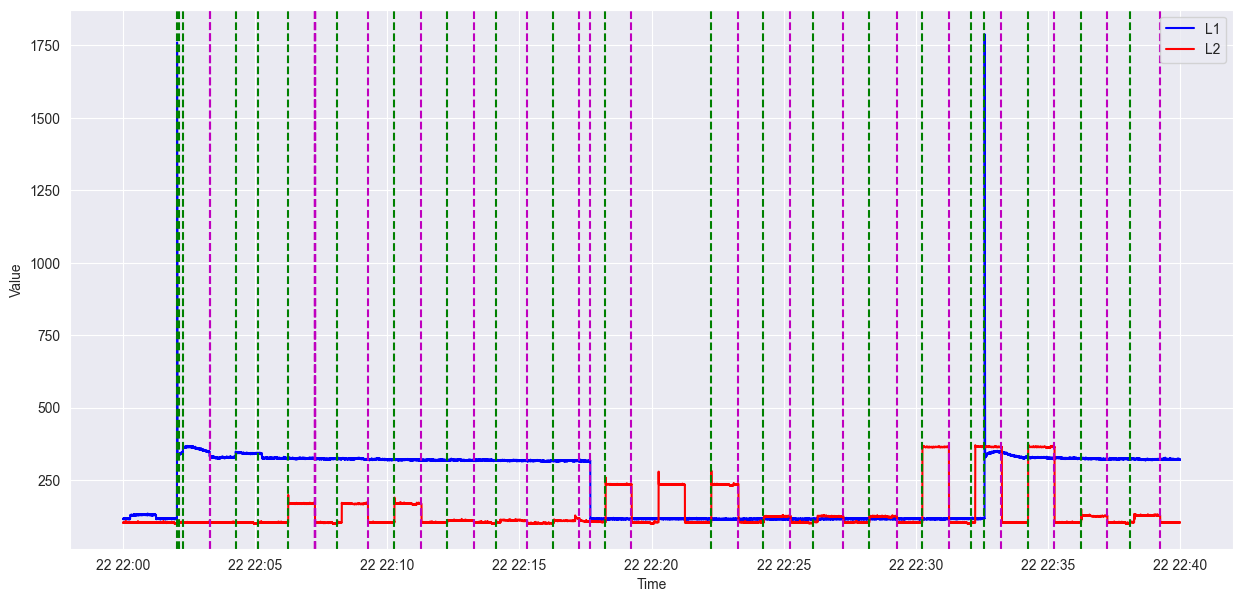

In [90]:
start_index, end_index = zoomIn("2012-10-22 23:00:00", "2012-10-22 23:40:00", time_ticks1_np)
plt.figure(figsize=(15, 7))

# This plots phase 1 and phase 2 separately (zoomed in)
plt.plot(TS1_real[start_index:end_index], L1_actual_power[start_index:end_index], linestyle='-', color='b', label='L1')
plt.plot(TS2_real[start_index:end_index], L2_actual_power[start_index:end_index], linestyle='-', color='r', label='L2')

event_times = [TS1_real[int(i)] for i in events_start if start_index <= i <= end_index]
for event_time in event_times:
    plt.axvline(event_time, color='g', linestyle='--')

event_times = [TS1_real[int(i)] for i in events_end if start_index <= i <= end_index]
for event_time in event_times:
    plt.axvline(event_time, color='m', linestyle='--')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Working on the model

###

In [83]:
normalized_phase1 = normalize(L1_actual_power)
normalized_phase2 = normalize(L2_actual_power)

###